# 初识NumPy与神经网络

## NumPy的使用

在本小节中，我们尝试着对 `start_code.c` 中的函数 `full_connect_forward` 进行向量化，以此介绍NumPy的部分使用方法。本节资料部分来自 [NumPy官方文档](https://numpy.org/doc/stable/index.html)。

以下是原始的C函数：

```c
float* full_connect_forward(float *const x, float *const w, float *const bias, int N, int K, int M) {
    // multiplication of two matrix actually
    float *const res = (float *const) malloc(sizeof(float) * N * M);
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < M; j++) {
            res[i*M + j] = bias[j];
            for (int k = 0; k < K; k++) {
                res[i*M + j] += x[i*K + k] * w[k*M + j];
            }
        }
    }
    return res;
}
```

我们试着用Python直接写出这段代码：

```python
def full_connect_forward(x, w, bias, N, K, M):
    res = []
    for i in range(N):
        row = []
        for j in range(M):
            sum = bias[j]
            for k in range(K):
                sum += x[i][k] * w[k][j]
            row.append(sum)
        res.append(row)
    return res
```

在上述这段代码中，假设输入的 `x` 与 `w` 都是Python内置的列表套列表的形式。接下来，我们用NumPy的数组 `np.ndarray` 来改写这段代码：

In [ ]:
import numpy as np
def full_connect_forward(x, w, bias):
    N, K = x.shape
    K, M = w.shape
    res = np.empty((N, M))
    # res = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            res[i, j] = bias[j]
            for k in range(K):
                res[i, j] += x[i, k] * w[k, j]
    return res

从这段代码可以看出，在使用NumPy时，与C语言一样，需要对将要用到的数组先进行内存分配。其中，被注释掉的 `np.zeros()` 函数会在分配内存的同时将分配到的内存清零。另外，任何 `np.ndarray` 对象都可以获取其 `shape`。我们可以设计一组简单的样例来测试这段代码：

In [ ]:
a = np.array([[1, 2], [3, 4], [5, 6]]) # 3, 2
b = np.array([[0, 1], [2, 3]]) # 2, 3
bias = np.array([1, 2])
res = full_connect_forward(a, b, bias)
print(res)

可以看出，我们转换的新代码是正确的。不难注意到，在最后一层循环中，实际上是将两个向量做点积的操作。因此，这一段代码可以进一步改写成：

```python
def full_connect_forward(x, w, bias):
    N, K = x.shape
    K, M = w.shape
    res = np.empty((N, M))
    # res = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            res[i, j] += np.dot(x[i, :] * w[:, j]) + bias[i]
    return res
```

其中，`x[i, :]` 中的冒号表示对这一维度进行切片。完整的用法是 `start:end:stride`，获得的切片不包含 `end` 元素。当有参数缺失时 NumPy 会自动推断并补充。因此，`x[i, :]` 获得了一个 `(1， K)` 的向量，而 `w[:, j]` 获得了一个 `(K, 1)` 的向量。通过对这两个向量求内积，即可获得结果。当然，更简便的向量化做法是直接用 `np.matmul()` 或 `@` 运算符进行矩阵乘法。但除了 `for` 循环，我们还有什么更简便的方法处理 `bias` 呢？

答案是利用 NumPy 的广播机制。如果我们将 `x(N, M)` 与 `y(M, )` 的两个数组相加，NumPy 会将 `y` 第二维的值“广播”到第一维上，即将 `y` 广播为 `(N, M)`，以此能正常相加。

In [ ]:
def full_connect_forward_vectorized(x, w, bias):
    return x @ w + bias

尝试测试其正确性：

In [ ]:
res = full_connect_forward_vectorized(a, b, bias)
print(res)

验证答案正确。除了使用 NumPy 的接口以及 NumPy 的广播等特性，还可以将所需要的运算转换成矩阵相乘的形式进行向量化加速运算，尽可能减少代码中的 `for` 循环。

在本题作答时，除了给出 `func_vectorized()` 的代码，同时也要比较 C 函数 `func()`， Python函数 `func()` 以及向量化后的函数 `func_vectorized()` 三者在相同规模数据下的运行速度。该测试的函数自选，要求不小于两个，并分析三者运行速度出现差异的原因。

## 卷积神经网络入门

首先，请阅读 [深度学习笔记](http://www.ai-start.com/dl2017/) 中第一门课的内容，通过 Logistic 回归模型认识神经网络。在完成阅读后，继续阅读本文，我们将设计一个全连接层类 `Linear`，并初步了解卷积神经网络的相关知识。

### 全连接层设计

在之前的学习中，我们已经见过了这张图：

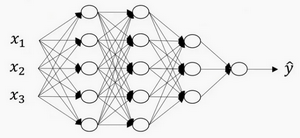

在这张图中，每一层都将前一层的所有节点与下一层的所有节点相连，这便是全连接的含义。而从数学上看，全连接层的输出是输入的一个线性变换，因此本文用 `Linear` 来表示全连接层。全连接层可训练的参数有 `weight(C, O)` 和 `bias(O, )`，正如你在前一节内容中所看到的那样。`C` 表示输入的大小，而 `O` 表示输出的大小。全连接层的计算公式为：

$$
y = x \cdot w + b
$$

其中 $x(N, C)$, $y(N, O)$。在之前的学习中，已经证明了全连接层的反向传播公式为：

$$
dw = x^T \cdot dy, dx = dy \cdot w^T
$$

根据以上的数学公式，我们可以设计出全连接层类：

In [ ]:
class Linear:
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.random.randn(in_features, out_features) * np.sqrt(2 / self.in_features)
        self.w_grad = np.zeros((in_features, out_features))
        if bias:
            self.bias = np.random.randn(out_features)
            self.b_grad = np.zeros(out_features)
        else:
            self.bias = None
        

    def forward(self, x):
        """
        x - shape (N, C)
        return the result of Linear layer with shape (N, O)
        """
        self.x = x
        x = x.reshape(x.shape[0], -1)
        if x.shape[1] != self.in_features:
            raise RuntimeError
        res = np.matmul(x, self.weight)
        if self.bias is not None:
            res += self.bias
        return res


    def backward(self, dy, lr):
        """
        dy - shape (N, O)
        lr - learning rate
        return the result of gradient dx with shape (N, C)
        """
        N, O = dy.shape
        if N != self.x.shape[0] or O != self.out_features:
            raise RuntimeError
        x = self.x.reshape(self.x.shape[0], -1)
        self.w_grad = np.matmul(x.T, dy) / N
        if self.bias is not None:
            self.b_grad = np.sum(dy, axis=0) / N

        dx = np.matmul(dy, self.weight.T).reshape(*self.x.shape)

        self.weight = self.weight - lr * self.w_grad
        if self.bias is not None:
            self.bias = self.bias - lr * self.b_grad
        return dx

在使用时，我们使用 `fc = Linear(C, O)` 来获取一个全连接层的对象。当我们执行这个代码时，首先会调用 `__init__()` 来初始化 `fc`。因此，在初始化过程中，我们需要储存 `fc` 对象的属性，同时也要初始化其包含的参数。

在正向传播时，我们通过 `y = fc.forward(x)` 储存该层的输入用于反向传播时梯度的计算，同时计算本层的输出。在反向传播时，我们通过 `dx = fc.backward(dy, lr)` 来更新该层的参数。同时计算该层输入的梯度并返回。

接下来我们通过一段样例来验证正确性：

In [ ]:
def Loss(y, label):
    y_pred = 1 / (1 + np.exp(-y))
    loss = np.mean(- label * np.log(y_pred) - (1 - label) * np.log(1 - y_pred))
    dy = y_pred - label
    return loss, dy

N = 16
C = 32
O = 1
x = np.random.rand(N, C) # input sample
y = np.random.randint(0, 2, (N, 1)) # label sample
fc = Linear(C, O)
for i in range(20000):
    output = fc.forward(x)
    loss, dy = Loss(output, y)
    fc.backward(dy, 1)
    if loss < 1e-2:
        print(f'Step {i} Loss: {loss}')
        break


可以看出，我们设计的全连接层是正常工作的，`loss` 在不断减小收敛至0。实际上，在上面这一段代码也给出了一种深度学习的模式，先设计一个模型类，实例化模型类，并不断地向模型对象中喂数据，计算损失函数并返回梯度，之后进行反向传播梯度下降。

### 池化层与卷积层

在卷积神经网络中，除了全连接层以外，还有两个最重要的网络层——卷积层与池化层：

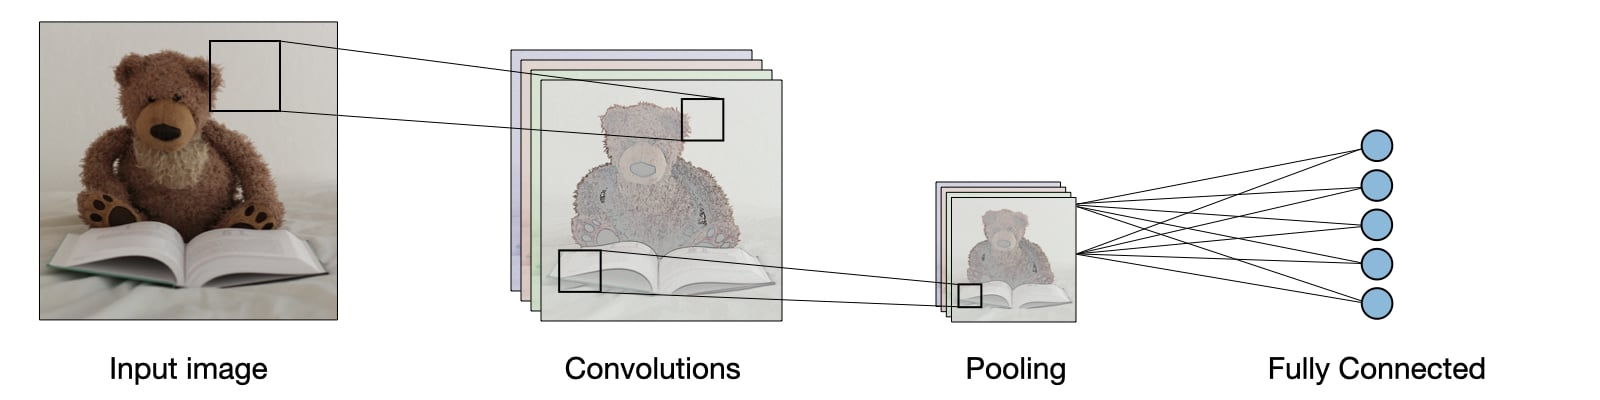

请阅读 [深度学习笔记](http://www.ai-start.com/dl2017/) 中第四周第一课的内容，了解卷积操作。实际上，在 `start_code.c` 中，我们给出了卷积与平均池化的代码。

在进行反向传播时，由于池化层的特性，我们只需要下一层的梯度传播至上一层有贡献的节点。例如，对于最大池化结果中的节点 `y[c, i, j]`，若其值由上一层输入中的节点 `x[c, k, l]` 贡献而来，则在反向传播时， `dx[c, k, l] += dy[c, i, j]`，而其他对池化层输出没有贡献的节点梯度为0。在平均池化中，由于一个节点为上一层多个节点的平均值，因此在反向传播时只需将该节点的梯度平均分配给上一层对其有贡献的所有节点。